In [1]:
import math
from scipy.stats import norm, skewnorm, cauchy, lognorm
import logging
import json
import sys
import os

import xlwt
import xlsxwriter
from tempfile import TemporaryFile
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

#%matplotlib inline
clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

pydice_folder = os.path.dirname(os.getcwd()) + '\\1_Model'
sys.path.append(pydice_folder)

from SALib.analyze import sobol

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.analysis import parcoords

from ema_workbench.em_framework.evaluators import perform_experiments, LHS, SOBOL, MORRIS
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring
# from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION

from ema_workbench.util import ema_logging
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.analysis import parcoords
from ema_workbench.analysis import clusterer, plotting, Density

from PyRICE_V8 import PyRICE

local path in PyRICE = 
C:\Users\ivart\OneDrive\Bureaublad\Afstuderen\WRR\PyRICE Ivar Tjallingii\PyRICE2020


In [2]:
nordhaus_policy = pd.read_excel("results_nordhaus_policy.xlsx")
nordhaus_policy = nordhaus_policy.drop(nordhaus_policy.columns[0], axis=1)

In [3]:
RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")

regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
    "Latin America","OHI","Other non-OECD Asia"]

"""
####################### Population PARAMETERS and set up dataframe format #######################
"""

#get population growth rates for each region
a=[]
for i in range(31):  
    if i == 0:
        a.append("region")
    k = 2005 + 10 * i
    k = str(k)
    a.append(k)    

region_pop_gr = RICE_POP_gr.iloc[10:22,3:35]
region_pop_gr.columns =  a
region_pop_gr = region_pop_gr.set_index('region') 

In [4]:
model = PyRICE(model_specification="Validation_1",welfare_function="utilitarian")
model()

damage function used:0
RICE Reference scenario is used
ygross at t = 1
[15.97331329 16.38071347  4.42562463  2.24695863  1.09321548 11.94050574
  4.60054419  5.7670217   2.45678464  7.11729629  5.09414936  4.17926155]
ygross at t = 1
[15.97331329 16.38071347  4.42562463  2.24695863  1.09321548 11.94050574
  4.60054419  5.7670217   2.45678464  7.11729629  5.09414936  4.17926155]
Nordhaus is used
Gross product at t = 1
[15.94811384 16.33609135  4.41754973  2.24336758  1.0912067  11.8760077
  4.57192902  5.73900195  2.44134182  7.10293135  5.0777975   4.16383755]
utilitarian SWF is used
0.015
[0.86166723 0.86166723 0.86166723 0.86166723 0.86166723 0.86166723
 0.86166723 0.86166723 0.86166723 0.86166723 0.86166723 0.86166723]
0.8616672317221843
period utility with WW at t = 1
[ 138.75032303  201.3851071    48.36808407   54.71239016   52.23450749
  640.20316085 -323.94345896  133.62198929 -340.954132    171.7704851
   59.92202179 -168.32650063]
##############################################

{'Damages 2005': 0.0,
 'Utility 2005': -1070.6545235875724,
 'Damages 2055': 2.387580412129832,
 'Utility 2055': 3015.324752057908,
 'Damages 2105': 11.175664064494374,
 'Utility 2105': 2518.327484336899,
 'Damages 2155': 24.482062852098736,
 'Utility 2155': 1474.7817242089695,
 'Damages 2205': 38.55062771265007,
 'Utility 2205': 757.8127956448534,
 'Damages 2305': 86.11623196580402,
 'Utility 2305': 194.0014219160982,
 'Total Aggregated Utility': 2257.1530406196853}

In [5]:
output_worst_off_income_class = pd.DataFrame(index =region_pop_gr.columns )
output_worst_off_climate_impact = pd.DataFrame(index =region_pop_gr.columns)
output_population_under_treshold =  pd.DataFrame(index =region_pop_gr.columns)
output_max_utility_distance_treshold = pd.DataFrame(index =region_pop_gr.columns)
output_intertemporal_utility_gini = pd.DataFrame(index =region_pop_gr.columns)
output_intertemporal_impact_gini = pd.DataFrame(index =region_pop_gr.columns)
output_climate_impact_per_dollar_gini = pd.DataFrame(index =region_pop_gr.columns)
output_utility_intra_gini = pd.DataFrame(index =region_pop_gr.columns)
output_regional_miu = pd.DataFrame(index =region_pop_gr.columns)

output_Y = pd.DataFrame(index =region_pop_gr.columns)
output_E = pd.DataFrame(index =region_pop_gr.columns)
output_U = pd.DataFrame(index =region_pop_gr.columns)
output_D = pd.DataFrame(index =region_pop_gr.columns)
output_T = pd.DataFrame(index =region_pop_gr.columns)

control_sr  = pd.DataFrame(index =region_pop_gr.columns)
control_miu_period  = pd.DataFrame(index =region_pop_gr.columns)
control_irstp  = pd.DataFrame(index =region_pop_gr.columns)

In [48]:
model()

run_name = "policy" + str(i)

#standard output
output_Y[run_name]  = model.global_ouput
output_E[run_name] = model.E_worldwilde_per_year
output_U[run_name] = model.global_per_util_ww
output_D[run_name] = model.global_damages
output_T[run_name] = model.temp_atm

#alternative objectives
output_worst_off_income_class[run_name] = model.worst_off_income_class
output_worst_off_climate_impact[run_name] = model.worst_off_climate_impact
output_population_under_treshold[run_name] =  model.population_under_treshold
output_max_utility_distance_treshold[run_name] = model.max_utility_distance_treshold
output_intertemporal_utility_gini[run_name] = model.intertemporal_utility_gini
output_intertemporal_impact_gini[run_name] = model.intertemporal_impact_gini 
output_climate_impact_per_dollar_gini[run_name] = model.climate_impact_per_dollar_gini
output_utility_intra_gini[run_name] = model.CPC_intra_gini
for region in range(0,12):
    run_name_region = "policy" + str(i) + "_region_"+ str(region)
    output_regional_miu[run_name_region]  = model.miu[region]

outcomes_dict = {}

outcomes_dict["Worst of income class"] = output_worst_off_income_class
outcomes_dict["Worst of climate impact"] = output_worst_off_climate_impact
outcomes_dict["Population under sufficitarian treshold"] = output_population_under_treshold
outcomes_dict["Maximum distance to treshold"] = output_max_utility_distance_treshold
outcomes_dict["Gini of intertemporal consumption"] = output_intertemporal_utility_gini
outcomes_dict["Gini of intertemporal climate impact"] = output_intertemporal_impact_gini
outcomes_dict["Gini of intratemporal relative impact"] = output_climate_impact_per_dollar_gini
outcomes_dict["Gini of intratemporal consumption"] = output_utility_intra_gini
outcomes_dict["Aggregated yearly output"] = output_Y
outcomes_dict["Aggregated yearly emissions"] = output_E
outcomes_dict["Aggregated yearly period utility"] = output_U
outcomes_dict["Aggregated yearly damages"] = output_D
outcomes_dict["Atmospheric temperature increase"] = output_T
outcomes_dict["Regional abatement level"] = output_regional_miu


damage function used:0
RICE Reference scenario is used
ygross at t = 1
[15.97331329 16.38071347  4.42562463  2.24695863  1.09321548 11.94050574
  4.60054419  5.7670217   2.45678464  7.11729629  5.09414936  4.17926155]
ygross at t = 1
[15.97331329 16.38071347  4.42562463  2.24695863  1.09321548 11.94050574
  4.60054419  5.7670217   2.45678464  7.11729629  5.09414936  4.17926155]
Nordhaus is used
Gross product at t = 1
[15.94811384 16.33609135  4.41754973  2.24336758  1.0912067  11.8760077
  4.57192902  5.73900195  2.44134182  7.10293135  5.0777975   4.16383755]
utilitarian SWF is used
0.015
[0.86166723 0.86166723 0.86166723 0.86166723 0.86166723 0.86166723
 0.86166723 0.86166723 0.86166723 0.86166723 0.86166723 0.86166723]
0.8616672317221843
period utility with WW at t = 1
[ 138.75032303  201.3851071    48.36808407   54.71239016   52.23450749
  640.20316085 -323.94345896  133.62198929 -340.954132    171.7704851
   59.92202179 -168.32650063]
##############################################

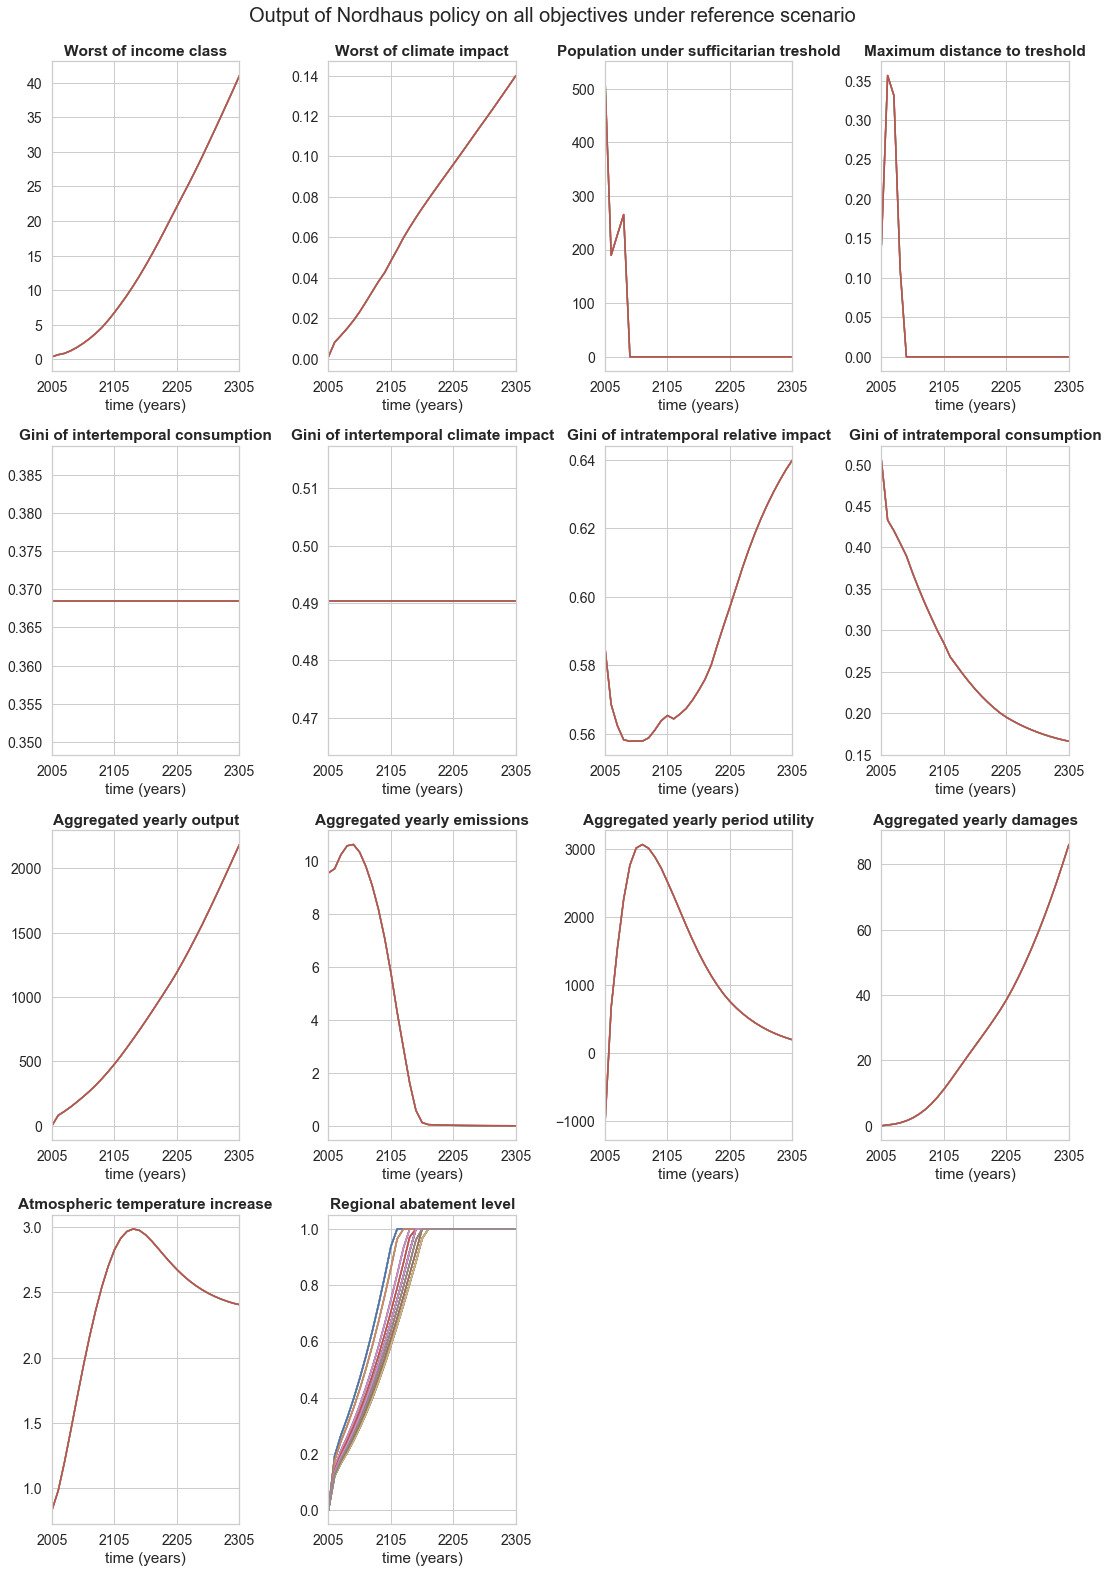

In [49]:
sns.set(font_scale=1.28)  # crazy big
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 22),constrained_layout=False)
fig.tight_layout(pad=3.0)

fig.delaxes(axes[3][3])
fig.delaxes(axes[3][2])

fig.suptitle("Output of Nordhaus policy on all objectives under reference scenario", fontsize=20,y=1.002)
#fig.subplots_adjust(hspace=1, wspace=0.2)

index_1 = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4]
index_2 = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1]
position = 0

for i in list(outcomes_dict.keys()):  
    data_sub_plot = outcomes_dict[i]
        
    for policy in range(0,len(data_sub_plot.columns)):        
        if policy == 0:
            data_sub_plot.iloc[:,policy].plot(ax=axes[index_1[position],index_2[position]]); 
            axes[index_1[position],index_2[position]].set_title(i,fontweight="bold"),
            axes[index_1[position],index_2[position]].set(xlabel='time (years)')
        else:
            data_sub_plot.iloc[:,policy].plot(ax=axes[index_1[position],index_2[position]],secondary_y=False)
    position = position + 1
            
plt.savefig("outcome of basecase.png", dpi=300)
    